In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as transforms
import os
from torchvision.io import decode_image
import matplotlib.pyplot as plt
from itertools import chain

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## NETWORK DEFINITIONS

# 256 channel residual block
class R256(nn.Module):
  def __init__(self):
    super(R256, self).__init__()
    # Architecture
    self.conv1 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, bias=False, padding='same', padding_mode='reflect')
    self.norm1 = nn.InstanceNorm2d(num_features=256)
    self.conv2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, bias=False, padding='same', padding_mode='reflect')
    self.norm2 = nn.InstanceNorm2d(num_features=256)
    self.relu = nn.ReLU(inplace=True)
  def forward(self, x):
    out = self.conv1(x)
    out = self.norm1(out)
    out = self.relu(out)
    out = self.conv2(out)
    out = self.norm2(out)
    # skip connection
    out = out + x
    out = self.relu(out)
    return out



In [ ]:
# Generator Class

class generator(nn.Module):
  def __init__(self):
    super(generator, self).__init__()
    # Convolution block
    # Kernel: 7, stride: 1, filters: 64
    # In: [B, 3, H, W]
    # Out: [B, 64, H, W]
    self.c7s1_64 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=1, padding='same', padding_mode='reflect'),
        nn.InstanceNorm2d(num_features=64),
        nn.ReLU(inplace=True)
        )
    # Downsampling block
    # In: [B, 64, H, W]
    # Out: [B, 128, H/2, W/2]
    self.d128 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
        nn.InstanceNorm2d(num_features=128),
        nn.ReLU(inplace=True)
    )
    # Downsampling block
    # In: [B, 128, H/2, W/2]
    # Out: [B, 256, H/4, W/4]
    self.d256 = nn.Sequential(
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),
        nn.InstanceNorm2d(num_features=256),
        nn.ReLU(inplace=True)
    )
    # Residual block
    # In: [B, 256, H/4, W/4]
    # Out: [B, 256, H/4, W/4]
    self.R256x9 = nn.Sequential(
        R256(),
        R256(),
        R256(),
        R256(),
        R256(),
        R256(),
        R256(),
        R256(),
        R256()
    )
    # Upsampling block
    # In: [B, 256, H/4, W/4]
    # Out: [B, 128, H/2, W/2]
    self.u128 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.InstanceNorm2d(num_features=128),
        nn.ReLU(inplace=True)
    )
    # Upsampling block
    # In: [B, 128, H/2, W/2]
    # Out: [B, 64, H, W]
    self.u64 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.InstanceNorm2d(num_features=64),
        nn.ReLU(inplace=True)
    )
    # Convolution block
    # In: [B, 64, H, W]
    # Out: [B, 3, H, W]
    self.c7s1_3 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=3, kernel_size=7, stride=1, padding='same', padding_mode='reflect'),
        nn.InstanceNorm2d(num_features=3),
        nn.Tanh()
    )
  def forward(self, x):
    out = self.c7s1_64(x)
    out = self.d128(out)
    out = self.d256(out)
    out = self.R256x9(out)
    out = self.u128(out)
    out = self.u64(out)
    out = self.c7s1_3(out)
    return out

In [ ]:
# Discriminator Class
## TODO: add input + output dims
class discriminator(nn.Module):
  def __init__(self):
    super(discriminator, self).__init__()
    self.c64 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1),
        nn.LeakyReLU(negative_slope=0.2)
    )
    self.c128 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1),
        nn.InstanceNorm2d(num_features=128),
        nn.LeakyReLU(negative_slope=0.2)
    )
    self.c256 = nn.Sequential(
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1),
        nn.InstanceNorm2d(num_features=256),
        nn.LeakyReLU(negative_slope=0.2)
    )
    self.c512 = nn.Sequential(
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=1, padding=1),
        nn.InstanceNorm2d(num_features=512),
        nn.LeakyReLU(negative_slope=0.2)
    )
    # IN:
    # Out: [B, 1, 14, 14]
    self.final = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=1)
  def forward(self, x):
    out = self.c64(x)
    out = self.c128(out)
    out = self.c256(out)
    out = self.c512(out)
    out = self.final(out)
    return out

In [ ]:
# Generative Adverserial Model
class GAN(nn.Module):
  def __init__(self, discriminator, generator):
    super(GAN, self).__init__()
    self.discriminator = discriminator
    self.generator = generator

  def forward(self, x):
    out = self.generator(x)
    out = self.discriminator(out)
    return out

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, img_paths, transform):
      self.img_paths = img_paths
      self.transform = transform
    def __len__(self):
      return len(self.img_paths)
    def __getitem__(self, idx):
      img_path = self.img_paths[idx]
      image = decode_image(img_path)
      image = self.transform(image)
      return image

In [ ]:
def get_img_paths(img_directory):
  image_paths = []
  for filename in os.listdir(img_directory):
      if filename.lower().endswith(('.jpg', '.jpeg')):
        fulA_path = os.path.join(img_directory, filename)
        image_paths.append(fulA_path)
  return image_paths

In [ ]:
def plot_image_and_translation(generator, image, img_dim):
  denormalize = transforms.Normalize(
    mean=[-1, -1, -1],
    std=[2, 2, 2]
  )
  with torch.no_grad():
    translation = generator(image).cpu()
    translation = denormalize(translation).numpy()
    translation = translation.reshape((3, img_dim, img_dim))
    translation = translation.transpose(1, 2, 0)
  image = image.detach().cpu()
  image = denormalize(image).numpy()
  image = image.reshape((3, img_dim, img_dim))
  image = image.transpose(1, 2, 0)

  plt.figure(figsize=(6,3))
  ax = plt.subplot(1, 2, 1)
  ax.axis('off')
  plt.imshow(image)
  ax = plt.subplot(1, 2, 2)
  ax.axis('off')
  plt.imshow(translation)
  plt.show()

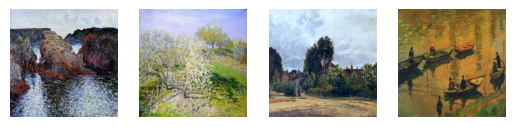

In [ ]:
# Instantiate datasets
denormalize = transforms.Normalize(
    mean=[-1, -1, -1],
    std=[2, 2, 2]
)
# Define transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)), # Resize to 128x128
    transforms.Compose([transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True)]), # Convert to PyTorch Tensor
    transforms.Lambda(lambda x: x[:3, :, :]), # Convert to RGB by selecting the first 3 channels
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # Normalize
])

# Instatiate landscape dataset
A_paths = get_img_paths('/content/drive/MyDrive/CycleGAN/domainA/trainA/')
A_dataset = ImageDataset(A_paths, transform)
# Visualize first 4 images
for i, image in enumerate(A_dataset):
    ax = plt.subplot(1, 4, i + 1)
    ax.axis('off')
    plt.imshow(denormalize(image).permute(1, 2, 0)) # permute to make it a numpy image from tensor

    if i == 3:
        plt.show()
        break

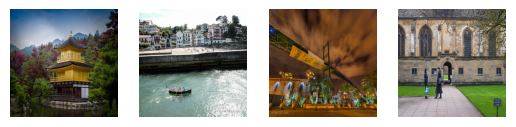

In [ ]:
# Instantiate datasets

# Denormalization for visualizing the image
denormalize = transforms.Normalize(
    mean=[-1, -1, -1],
    std=[2, 2, 2]
)

# Define transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)), # Resize to 128x128
    transforms.Compose([transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True)]), # Convert to PyTorch Tensor
    transforms.Lambda(lambda x: x[:3, :, :]), # Convert to RGB by selecting the first 3 channels
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # Normalize
])

# Instatiate landscape dataset
B_paths = get_img_paths('/content/drive/MyDrive/CycleGAN/domainB/trainB/')
B_dataset = ImageDataset(B_paths, transform)
# Visualize first 4 images
for i, image in enumerate(B_dataset):
    ax = plt.subplot(1, 4, i + 1)
    ax.axis('off')
    plt.imshow(denormalize(image).permute(1, 2, 0)) # permute image dims to make it (H, W, C) from (C, H, W)

    if i == 3:
        plt.show()
        break

In [ ]:
# Instantiate dataloaders
batch_size = 1
A_dataloader = DataLoader(A_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
B_dataloader = DataLoader(B_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
## TRAINING

# Instatiate Generator_BA
Generator_BA = generator().to(device)
PL_state_dict = torch.load('/content/drive/MyDrive/CycleGAN/models/Generator_BA_iter1000e36.pth', map_location=torch.device(device))
Generator_BA.load_state_dict(PL_state_dict)
# Instantaite Generator_AB
Generator_AB = generator().to(device)
LP_state_dict = torch.load('/content/drive/MyDrive/CycleGAN/models/Generator_AB_iter1000e36.pth', map_location=torch.device(device))
Generator_AB.load_state_dict(LP_state_dict)
# Instantaite DiscriminatorL
Discriminator_A = discriminator().to(device)
L_state_dict = torch.load('/content/drive/MyDrive/CycleGAN/models/Discriminator_A_iter1000e36.pth', map_location=torch.device(device))
Discriminator_A.load_state_dict(L_state_dict)
#Instantaite DiscriminatorP
Discriminator_B = discriminator().to(device)
P_state_dict = torch.load('/content/drive/MyDrive/CycleGAN/models/Discriminator_B_iter1000e36.pth', map_location=torch.device(device))
Discriminator_B.load_state_dict(P_state_dict)
# Instantiate GAN_BA
GAN_BA = GAN(Discriminator_A, Generator_BA)
# Instantiate GAN_AB
GAN_AB = GAN(Discriminator_B, Generator_AB)

# Optimizer for the GANs
optimizer_GANs = torch.optim.Adam(
    chain(Generator_BA.parameters(), Generator_AB.parameters()), lr=0.0002, betas=(0.5, 0.999)
)

# Optimizer for Discriminator_A
optimizer_disc_A = torch.optim.Adam(Discriminator_A.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Optimizer for Discriminator_B
optimizer_disc_B = torch.optim.Adam(Discriminator_B.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Criterion for GANs
criterion_GANs = nn.MSELoss()

# Criterion for cycle consistency
criterion_cycle = nn.L1Loss()

# Criterion for identity
criterion_id = nn.L1Loss()


In [ ]:
def train(A_dataloader,
    B_dataloader,
    Generator_BA,
    Generator_AB,
    Discriminator_A,
    Discriminator_B,
    GAN_BA,
    GAN_AB,
    optimizer_disc_A,
    optimizer_disc_B,
    criterion_GANs,
    criterion_cycle,
    criterion_id,
          epoch):
  lambda_cycle = 10
  lambda_identity = 0.5*lambda_cycle
  i = 0
  for real_image_A, real_image_B in zip(A_dataloader, B_dataloader):
    ## GET REAL AND FAKE IMAGES
    ## ------------------------
    real_image_A = real_image_A.to(device)
    real_image_B = real_image_B.to(device)
    fake_image_A = Generator_BA(real_image_B)
    fake_image_B = Generator_AB(real_image_A)
    ## TRAIN Discriminator_A
    ## ---------------------
    optimizer_disc_A.zero_grad()
    pred_dA_real = Discriminator_A(real_image_A)
    loss_dA_real = criterion_GANs(pred_dA_real, torch.ones_like(pred_dA_real).to(device))
    pred_dA_fake = Discriminator_A(fake_image_A.detach())
    loss_dA_fake = criterion_GANs(pred_dA_fake, torch.zeros_like(pred_dA_fake).to(device))
    loss_disc_A = 0.5*(loss_dA_real+loss_dA_fake)
    loss_disc_A.backward()
    optimizer_disc_A.step()
    ## TRAIN Discriminator_B
    ## ---------------------
    optimizer_disc_B.zero_grad()
    pred_dB_real = Discriminator_B(real_image_B)
    loss_dB_real = criterion_GANs(pred_dB_real, torch.ones_like(pred_dB_real).to(device))
    pred_dB_fake = Discriminator_B(fake_image_B.detach())
    loss_dB_fake = criterion_GANs(pred_dB_fake, torch.zeros_like(pred_dB_fake).to(device))
    loss_disc_B = 0.5*(loss_dB_real+loss_dB_fake)
    loss_disc_B.backward()
    optimizer_disc_B.step()
    ## TRAIN GENERATORS
    ## ----------------
    optimizer_GANs.zero_grad()
    # Adversarial loss
    pred_GAN_AB = GAN_AB(real_image_A)
    pred_GAN_BA = GAN_BA(real_image_B)
    adv_loss_GAN_AB = criterion_GANs(pred_GAN_AB, torch.ones_like(pred_GAN_AB).to(device))
    adv_loss_GAN_BA = criterion_GANs(pred_GAN_BA, torch.ones_like(pred_GAN_BA).to(device))
    # Cycle consistency loss
    recovered_image_A = Generator_BA(fake_image_B)
    recovered_image_B = Generator_AB(fake_image_A)
    cycle_loss_AB = criterion_cycle(recovered_image_B, real_image_B)
    cycle_loss_BA = criterion_cycle(recovered_image_A, real_image_A)
    # Identity loss
    identity_image_B = Generator_AB(real_image_B)
    identity_image_A = Generator_BA(real_image_A)
    identity_loss_B = criterion_id(real_image_B, identity_image_B)
    identity_loss_A = criterion_id(real_image_A, identity_image_A)
    GAN_loss = (adv_loss_GAN_AB + adv_loss_GAN_BA + lambda_cycle*(cycle_loss_AB + cycle_loss_BA)
                + lambda_identity*(identity_loss_A + identity_loss_B)
    )
    GAN_loss.backward()
    optimizer_GANs.step()
    if (i%1000==0):
      plot_image_and_translation(generator=Generator_AB, image=real_image_A, img_dim=256)
      plot_image_and_translation(generator=Generator_BA, image=real_image_B, img_dim=256)
      AB_path = f"/content/drive/MyDrive/CycleGAN/models/Generator_AB_iter{i}e{epoch}.pth"
      BA_path = f"/content/drive/MyDrive/CycleGAN/models/Generator_BA_iter{i}e{epoch}.pth"
      A_path = f"/content/drive/MyDrive/CycleGAN/models/Discriminator_A_iter{i}e{epoch}.pth"
      B_path = f"/content/drive/MyDrive/CycleGAN/models/Discriminator_B_iter{i}e{epoch}.pth"
      torch.save(Generator_AB.state_dict(), AB_path)
      torch.save(Generator_BA.state_dict(), BA_path)
      torch.save(Discriminator_A.state_dict(), A_path)
      torch.save(Discriminator_B.state_dict(), B_path)
    i += 1

Epoch: 0


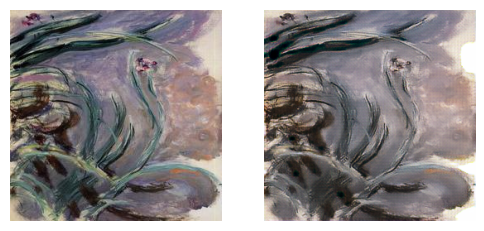

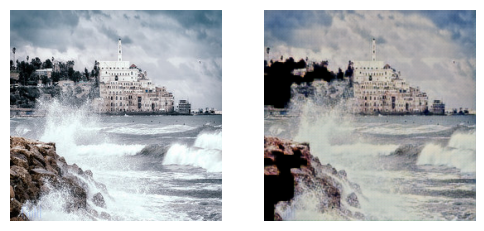

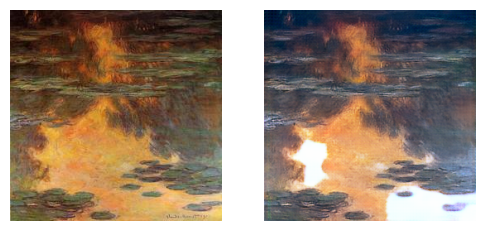

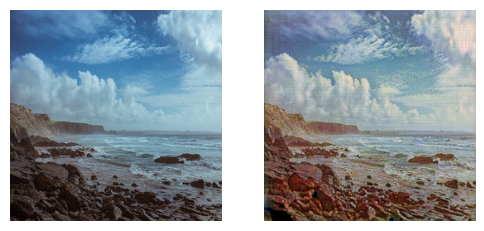

Epoch: 1


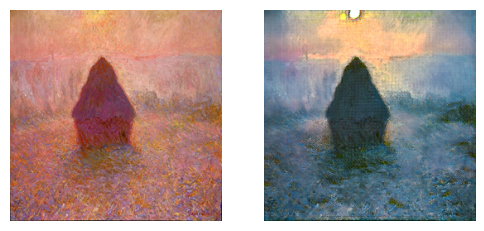

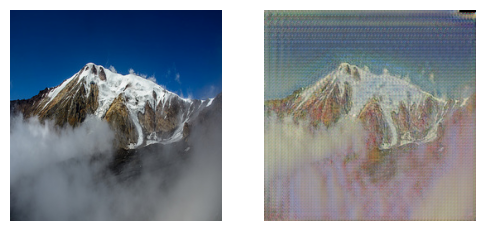

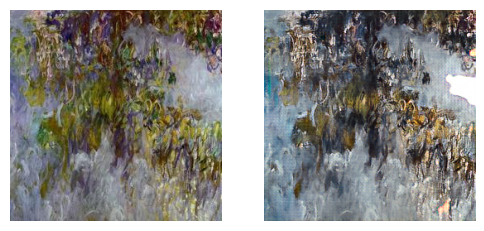

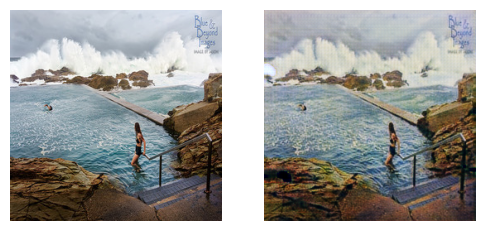

Epoch: 2


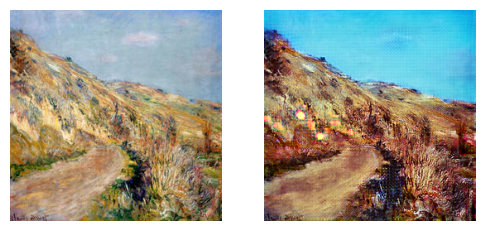

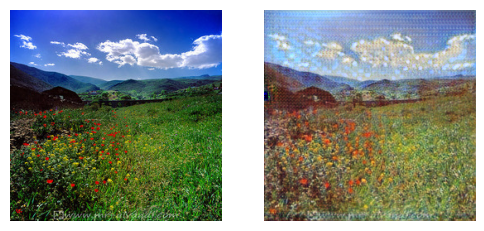

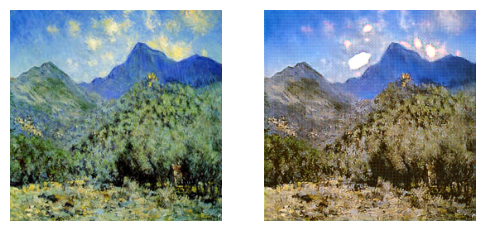

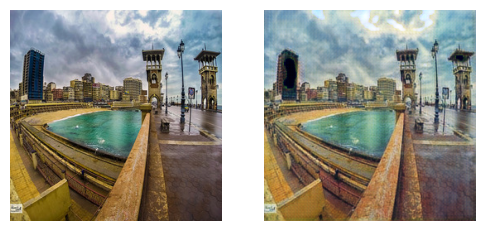

Epoch: 3


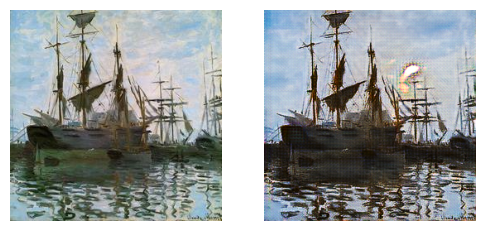

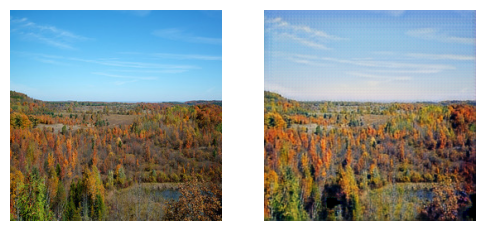

In [ ]:
num_epochs = 100
for epoch in range(num_epochs):
  print(f"Epoch: {epoch}")
  train(A_dataloader,
    B_dataloader,
    Generator_BA,
    Generator_AB,
    Discriminator_A,
    Discriminator_B,
    GAN_BA,
    GAN_AB,
    optimizer_disc_A,
    optimizer_disc_B,
    criterion_GANs,
    criterion_cycle,
    criterion_id,
        epoch)

In [ ]:
for i, image in enumerate(A_dataset):

  plot_image_and_translation(generator=Generator_AB, image=image.to(device), img_dim=256)
  if (i==20):
    plt.show()
    break